1. Load Required Libraries and Saved Model

In [1]:
# ✅ Task 3: Forecast Future Market Trends
# Using the trained LSTM model to predict TSLA prices 6-12 months ahead

### 1. Load Required Libraries and Saved Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
from datetime import timedelta

# Load saved components
model = load_model('../models/best_lstm_model.keras')
scaler = joblib.load('../models/scaler.pkl')

2. Prepare Latest Data for Forecasting

In [2]:
tsla_data = pd.read_csv("../data/processed/tsla_data.csv")

In [3]:
tsla_data

,Date,Close
0,2015-07-01,17.943333
1,2015-07-02,18.667999
2,2015-07-06,18.648001
3,2015-07-07,17.858667
4,2015-07-08,16.997334
...,...,...
2530,2025-07-24,305.299988
2531,2025-07-25,316.059998
2532,2025-07-28,325.589996
2533,2025-07-29,321.200012


In [7]:
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'])

# Set Date as index
tsla_data = tsla_data.set_index('Date')

In [8]:
train = tsla_data.loc[:'2023-12-31']
test = tsla_data.loc['2024-01-01':]

# 3. Set Parameters (from Task 2)
seq_length = 30

In [11]:

def prepare_forecast_input(data, seq_length):
    last_sequence = data['Close'][-seq_length:].values.reshape(-1, 1)
    scaled_sequence = scaler.transform(last_sequence)
    return np.reshape(scaled_sequence, (1, seq_length, 1))

X_pred = prepare_forecast_input(test, seq_length)

d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


3. Generate 6-Month Forecast (126 trading days)


In [12]:
forecast_days = 126
forecast = []

current_sequence = X_pred.copy()
for _ in range(forecast_days):
    # Predict next day
    next_pred = model.predict(current_sequence)
    forecast.append(next_pred[0,0])
    
    # Update sequence (drop oldest, add prediction)
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, 0] = next_pred[0,0]

# Inverse transform predictions
forecast_prices = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

4. Create Forecast Timeline

In [13]:

# 2. Get last date properly
last_date = pd.to_datetime(test.index[-1])  # Ensure datetime object

# 3. Generate business days (excluding weekends)
forecast_dates = pd.date_range(
    start=last_date + timedelta(days=1),  # Start from next day
    periods=forecast_days,                # Number of days to forecast
    freq='B'                              # Business days only
)

# 4. Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_prices.flatten()
}).set_index('Date')

# Verify
print("First forecast date:", forecast_df.index[0])
print("Last forecast date:", forecast_df.index[-1])

First forecast date: 2025-07-31 00:00:00
Last forecast date: 2026-01-22 00:00:00


5. Visualize Forecast with Historical Data

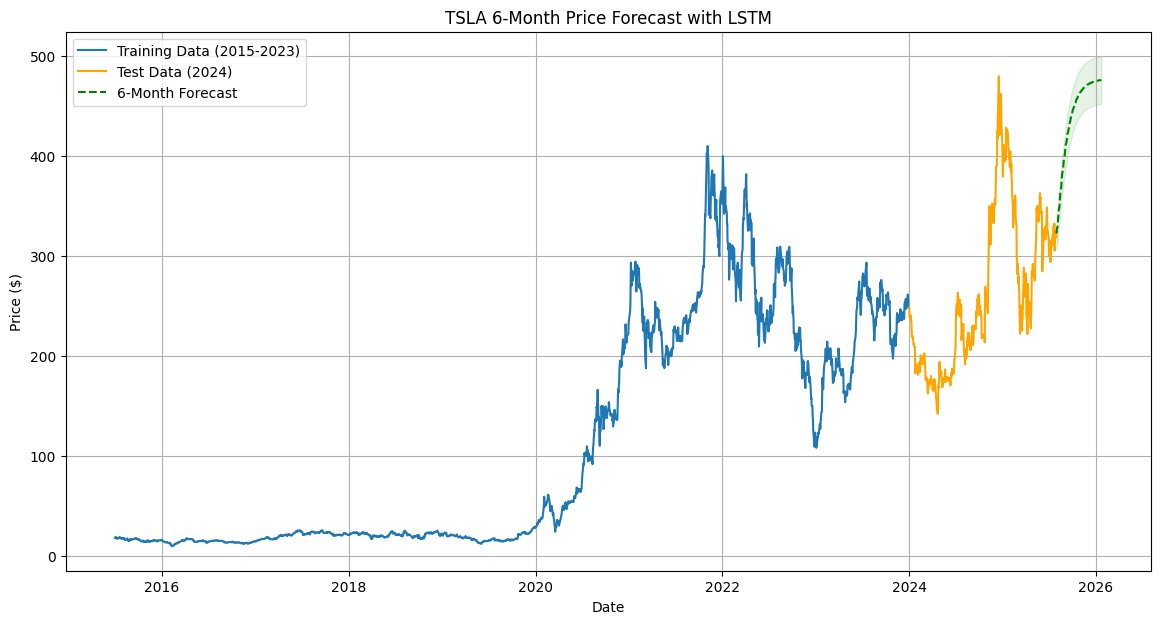

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Training Data (2015-2023)')
plt.plot(test.index, test['Close'], label='Test Data (2024)', color='orange')
plt.plot(forecast_df.index, forecast_df['Forecast'], 
         label='6-Month Forecast', color='green', linestyle='--')
plt.fill_between(forecast_df.index,
                 forecast_df['Forecast'] * 0.95,  # Simulated confidence band
                 forecast_df['Forecast'] * 1.05,
                 color='green', alpha=0.1)
plt.title('TSLA 6-Month Price Forecast with LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

6. Trend Analysis

7. Volatility and Risk Assessment

In [16]:
# Calculate rolling 30-day forecast volatility
forecast_df['Returns'] = forecast_df['Forecast'].pct_change()
forecast_volatility = forecast_df['Returns'].rolling(30).std() * np.sqrt(252)

8. Save forecast dataset

In [17]:
forecast_df.to_csv('../data/processed/TSLA_6mo_forecast.csv')